# Transfer learning in computer vision

> Fine-tuning a pretrained model on the pets dataset.

In [ ]:
from local.torch_basics import *
from local.test import *
from local.core import *
from local.layers import *
from local.data.all import *
from local.optimizer import *
from local.learner import *
from local.metrics import *
from local.callback.all import *
from local.vision.core import *
from local.vision.augment import *
from local.vision.models import *
from local.vision.learner import *
from local.data.block import *

## Gathering the data

We use the data block API to get our data in a `DataBunch`. Here our inputs are images and our targets categories. The images are all in a folder, so we use `get_image_files` to collect them all, a `RandomSplitter` to split between training and validation, then we get the label from the filenames with a regex labeller.

In [ ]:
pets = DataBlock(ts=(PILImage, Category), 
                 get_items=get_image_files, 
                 splitter=RandomSplitter(),
                 get_y=RegexLabeller(pat = r'/([^/]+)_\d+.jpg$'))

The pets object by itself is empty: it only containes the functions that will help us gather the data. We have to call its `datasource` or `databunch` method to get a `DataSource` or a `DataBunch`. The first thing we need to pass to either of those functions is the source, here the folder where all the images are. Then we specify some dataset transforms (a random resized crop to 300 by 300) and some dataloader transforms (basic data augmentation on the GPU and normalization using the imagenet statistics).

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
imagenet_stats = broadcast_vec(1, 4, *imagenet_stats)

In [ ]:
dbunch = pets.databunch(untar_data(URLs.PETS)/"images", ds_tfms=RandomResizedCrop(300, min_scale=0.5), bs=64,
                        dl_tfms=[*aug_transforms(size=224), Normalize(*imagenet_stats)])

Then we can look at some of our pictures with `dbunch.show_batch()`

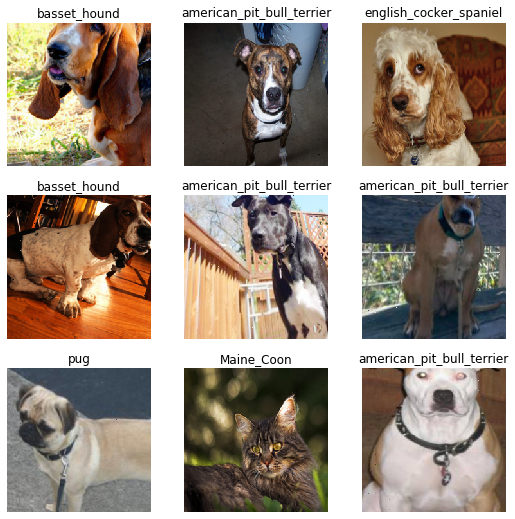

In [ ]:
dbunch.show_batch(max_n=9)

## Using a pretrained model

First let's import a `resnet34` form torchvision.

In [ ]:
from torchvision.models import resnet34

We will use the AdamW optimizer (Adam with true weight decay).

In [ ]:
opt_func = partial(Adam, lr=3e-3, wd=0.01)

Then we can call `cnn_learner` to build a `Learner` from our `DataBunch`. Since we are using a pretrained model, it comes automatically frozen, which means only the head is going to be trained.

In [ ]:
from local.vision.learner import _resnet_split
learn = cnn_learner(dbunch, resnet34, loss_func=CrossEntropyLossFlat(), cut=-2, splitter = _resnet_split, opt_func=opt_func, metrics=error_rate)

We can train the head a little bit using the 1cycle policy.

In [ ]:
x,y = dbunch.one_batch()
x.device

device(type='cuda', index=6)

In [ ]:
learn.fit_one_cycle(4, lr_max=3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.945678,0.307534,0.101489,00:14
1,0.523729,0.252230,0.086604,00:14
2,0.351005,0.236116,0.072395,00:14
3,0.250921,0.201760,0.069012,00:14


Then we can unfreeze the model and use discriminative learning rates.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, lr_max=np.array([1e-6, 1e-5, 1e-4]))

epoch,train_loss,valid_loss,error_rate,time
0,0.232952,0.202267,0.064953,00:17
1,0.209773,0.193974,0.060893,00:17
